In [1]:
#Todas estas librerias están en el archivo requirements.txt
#pip install cryptocmd
#pip install statsmodels
#pip install skforecast
#pip install lightgbm
#pip install ipywidgets

In [2]:
#Data---------------
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper
#Plot--------------
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')
#Colors----------
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }
# Modelling and Forecasting----
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error


In [3]:
# Data download
# ==============================================================================
# Scraper is initialized, symbol, start and end of download are included
scraper = CmcScraper('BTC', '28-04-2013', '01-01-2022')
# Transform collected data into a dataframe
data = scraper.get_dataframe()
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2022-01-01,46311.744663,47827.310995,46288.486095,47686.811509,2.458267e+10,9.021042e+11
1,2021-12-31,47169.372859,48472.527490,45819.954553,46306.446123,3.697417e+10,8.759394e+11
2,2021-12-30,46490.606049,47879.965500,46060.313166,47178.125843,2.668649e+10,8.923863e+11
3,2021-12-29,47623.870463,48119.740950,46201.494371,46444.710491,3.004923e+10,8.784788e+11
4,2021-12-28,50679.859377,50679.859377,47414.209925,47588.854777,3.343038e+10,9.000762e+11


In [4]:
DeepnoteChart(data, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"log","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"log","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [5]:
DeepnoteChart(data, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

If you press the button "Visualize" in the data.head(), it allows you to plot the data in a easy way. The following is the price "close" in logarithmic scale. 

We change the order of the values in ascending order with data.sort_values. 

In [6]:
data.sort_values(by='Date', ascending=True, inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
3170,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.0,1.488567e+09
3169,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09
3168,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09
3167,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09
3166,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09


We prepare the data. I honestly think this step, in this case, is not nessesary. For other datasets (other formats) it might be very important to apply the following lines. I include at the end a 'different way' to change the capital letters:  

In [7]:
# Data preparation
# ==============================================================================
#data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
#data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
#data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
#                    axis=1)
data.set_axis(list(map(lambda x: x.lower(),list(data.columns))),axis='columns',inplace=True)
data = data.set_index('date')
#data = data.asfreq('D') #(*No entiendo esta linea*) 
#data = data.sort_index()

#Para graficar respecto al indice se utiliza:
#sns.set_style("whitegrid")
#plt.figure(figsize=(10, 6))
#sns.lineplot(data=data,x=data.index,y='close')

We count the number of times that appear a null value:  

In [8]:
print(f'Number of rows with missing values:\n {data.isnull().sum()}')

Number of rows with missing values:
 open          0
high          0
low           0
close         0
volume        0
market cap    0
dtype: int64


### Variables exógenas

Vemos ahora las variables exógenas a los bitcoins, y como estás variables afectan el precio de los bitcoins durante el tiempo. Cada 4 años se ve una reducción a la mitad del 'reward' del bitcoin minado. Esto a pasado 3 veces en la historia (2012, 2016 y 2020), la próxima reducción del reward será aproximadamente en 2024. La reducción depende de la cantidad de bloques agregados al 'blockchain', la minería de bitcoins se encarga de agregar bloques (que dependen de los anteriores). El tamaño total  de bloques para cada reducción está dada por el halving_block_number (*Tengo que entender esta parte*). Por día, la cantidad de bloques minados es aproximadamente 144 (1 cada 10 min) y al día 2022-01-14 la cantidad de bloques restantes es 121.400 (*Al parecer la cantidad de bloques es fija. Tengo que entender mejor esta parte*). Al poner esta variable exógena, el error asociado a la variable es introducida en el modelo de forecasting. Creamos un diccionario con la reducción histórica:      

In [9]:
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

Ahora calculamos con la data de coinmarketcap la fecha aproximada de la siguiente reducción del reward. Tomamos el día 2022-01-14 como punto inicial, del cual conocemos la cantidad de bloques restantes,    

In [10]:
remaining_blocks = 121400
blocks_per_day = 144

days = remaining_blocks / blocks_per_day

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=days)
print(next_halving)

2024-05-06 01:20:00


Solo nos interesa el día, 

In [11]:
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'The next halving will occur on approximately: {next_halving}')
print(btc_halving['date'])

The next halving will occur on approximately: 2024-05-06
['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-05-06']


Agregamos nuevas columnas 'reward' y 'countdown_halving' al dataset y las llenamos 

In [12]:
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Start and end date of each halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')  
    else:
        start_date = btc_halving['date'][i]
        
        ###Esta es la parte importante, estamos creando una mascara booleana. 
        ###Donde los "True" van a coincidir con el índice correspondiente a la fecha que se cumple la condición anterior.    
        end_date = btc_halving['date'][i+1]
        mask = (data.index >= start_date) & (data.index < end_date)  
        
        ###Acá llenamos la columna reward con el btc_halving del indice (i) correspondiente solo si se cumple la mascara booleana.
        data.loc[mask, 'reward'] = btc_halving['reward'][i] 
       
        # Fill column 'countdown_halving' with remaining days
        time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
        data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

### Exploración gráfica

Creamos una figura que indica una pendiente positiva (verde) o negativa (roja) para los valores Open y Close. Este tipo de gráfico se llama Candlestick Chart y se utilizan ampliamente en economía. Definimos los parámetros del candlestick, con los datos del dataset 

In [13]:
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])
fig.show()

Vemos que las variaciones positivas están en verde y las negativas en rojo. Agregamos algunos marcadores para identificar los halvings, 

In [14]:
fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Second halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Third halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Fourth halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

Calculamos el KDE, para los precios de la columna 'close'. El KDE es simplemente una función (suave) de densidad de probabilidad que se construye con el histograma de los datos. Donde, la vecindad de cada dato se suaviza, con una distribución normal que depende de un parámetro 'bandwith' (desviación típica). Para un bandwith pequeño, obtenemos pikes en la distribución normal mas centrados en cada punto del histograma. Un bandwith grande, los pikes se difuminan y no son tan notorios. Adjunto una imagen de ejemplo, con el KDE para bandwiths 0.05, 0.1 y 0.3. Por lo general, este tipo de gráficos está acompañado de un rugplot (lineas en x) el rugplot, nos da cuenta de la distribución de puntos en la data.                    

![Picture title](image-20230703-152627.png)

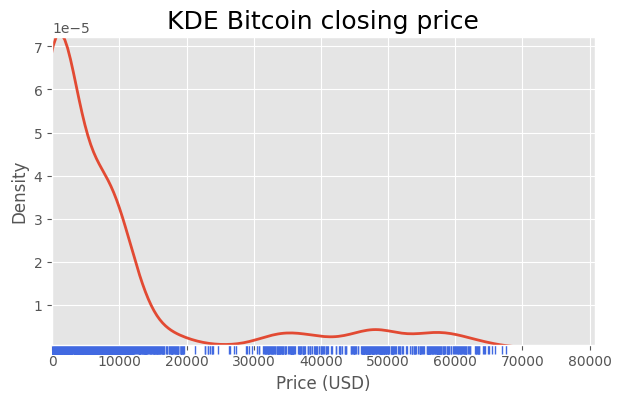

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=2, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin closing price', fontsize=18)
p.set_xlabel('Price (USD)');

Vemos que la distribución es altamente dispar para los valores < 20k USD y > 20k USD. Esta disparidad implicará complicaciones en la serie de tiempo a la hora de hacer una predicción. Una estrategia es usar, en vez de precios de forma directa, considerar deltas de precios, de esta forma obtenemos una distribución más simétrica. También creo que linealizando los datos, podríamos conseguir lo mismo.    

Según ChatGPT:  por qué, en las series de tiempo, una disparidad grande entre los valores de la serie significan una complicación al hacer un forecast?

Una disparidad grande entre los valores de una serie de tiempo puede dificultar la predicción o el pronóstico futuro debido a varias razones:

Patrones y tendencias ocultas: Una serie de tiempo con una gran disparidad entre los valores puede indicar la presencia de patrones y tendencias ocultas en los datos. Estos patrones pueden dificultar la identificación de relaciones consistentes entre las variables y, por lo tanto, hacer que sea más difícil predecir el comportamiento futuro.

Variabilidad no sistemática: Una disparidad grande entre los valores de la serie puede ser el resultado de variabilidad no sistemática o ruido en los datos. Esto podría deberse a factores aleatorios, como perturbaciones o eventos impredecibles, que no siguen un patrón discernible. Esta variabilidad no sistemática puede dificultar la identificación de relaciones de causa y efecto entre las variables y, por lo tanto, dificultar las predicciones precisas.

Violación de supuestos de modelos: Muchos modelos de pronóstico se basan en supuestos sobre la estacionariedad y la linealidad de los datos. Si una serie de tiempo muestra una disparidad grande entre los valores, es posible que no cumpla con estos supuestos. Esto puede hacer que los modelos de pronóstico tradicionales sean menos efectivos y requieran técnicas más avanzadas o modelos no lineales para obtener predicciones precisas.

Sesgo en los datos históricos: Si una serie de tiempo muestra una gran disparidad entre los valores históricos, esto puede sesgar los modelos de pronóstico hacia valores atípicos o poco representativos. Los modelos de pronóstico generalmente se basan en patrones y comportamientos pasados para predecir el futuro, pero si estos patrones no son consistentes debido a una gran disparidad, los pronósticos pueden ser menos precisos.

En resumen, una disparidad grande entre los valores de una serie de tiempo puede complicar el pronóstico debido a la presencia de patrones ocultos, variabilidad no sistemática, violación de supuestos de modelos y sesgo en los datos históricos. Es importante analizar y abordar adecuadamente estas complicaciones para mejorar la precisión de las predicciones en series de tiempo.

Ahora calculamos el precio por año, para eso creamos una nueva lista 'years', que incluye cada año dentro del índice. Creamos un nuevo dataframe llamado 'df_plot'.    

In [16]:
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    ## Acá, asignamos los valores para open, close, low y high para nuestro nuevo dataframe df_plot.
    ## El dataframe finalmente tendrá 10 filas desde 2013 a 2022. Y columnas 'open', 'close', 'low' y 'high'.     
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 

## En este punto las columnas están etiquetadas por año y las filas son los valores 'open', 'close', 'low' y 'high'.
## Tenemos que transformar el dataframe tomando la traspuesta.       
df_plot = df_plot.T

# Renombramos las columnas 
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

## Agregamos la columna year_change en el df_plot.   
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(10)

,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526
2016,430.721008,963.742981,354.914001,979.396973,123.751097
2017,963.658020,14156.400391,755.755981,20089.000000,1369.027404
2018,14112.200195,3742.700335,3191.303562,17712.400391,-73.478974
2019,3746.713387,7193.598978,3391.023752,13796.489081,91.997579
2020,7194.891971,29001.719822,4106.980750,29244.876688,303.087634
2021,28994.008916,46306.446123,28722.755271,68789.625939,59.710395
2022,46311.744663,47686.811509,46288.486095,47827.310995,2.969154


(Pendiente) Terminar este gráfico

### Simulación: Random Walk 

En finanzas, existe la teoría 'random walk hypothesis' https://en.wikipedia.org/wiki/Random_walk_hypothesis. El modelo es de la siguiente forma,   

![Picture title](image-20230704-164342.png)

donde i.i.d. se refiere a (Independent and identically distributed). Este modelo determina una variación completamente random del precio de los activos del mercado (en nuestro caso, el precio del bitcoin). Hay muchos investigadores que aseguran (aparentemente esto no ha sido completamente probado, aunque hay muchos ejemplos que lo comprueban: https://press.princeton.edu/books/paperback/9780691092560/a-non-random-walk-down-wall-street) cierta predictibilidad del precio de los activos, este modelo se le conoce por 'non-random walk hypothesis'. Ya que los precios se mueven según 'trends', de esta forma podríamos predecir la dirección del precio en el futuro utilizando la información del pasado.          

![Picture title](image-20230704-165855.png)

Donde E[ ], son los 'expectation operators', o valor esperado de las variables aleatorias. Notamos que $epsilon_{t}$ es una variable aleatoria que depende del punto t. Por lo tanto, no es exactamente un 'random walk'. Para hacer la simulación, utilizaremos los últimos 2 años ya que las diferencias de precios para el resto del tiempo, hace complejo hacer una buena predicción (Podríamos intentar ver esta diferencia). Vamos a definir las fechas de inicio y de término de la simulación,                  

In [17]:
# Fechas de inicio y de término de la simulación
start_train = '2020-01-01 00:00:00'
end_train = '2021-06-30 23:59:59'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00  (n=3171)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00  (n=185)


Comenzamos con un simple ejemplo. Creamos un dataframe df_rw, con los datos shifteados. Después usamos la función 'mean_absolute_error' desde 'sklearn.metrics' simplemente haciendo un shift de los datos originales y desde acá definimos la métrica.  

In [18]:
# Random walk simulation (test error) | Creamos un dataframe df_rw copiando la data de la columna 'close', después la shifteamos. 
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Los valores y_true y y_pred comienzan desde el valor end_train, para eso es el (:) 
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']

# Calculamos mean absolute error (MAE = \sum_{i}^{n} \frac{y_{i}-x_{i}}{n}) desde sklearn.metrics
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')

Test error: 1267.7978352283603


Esta parte del código es pensado solo para dar una idea de la métrica y como se relaciona con el mean_absolute_error, la idea es mejorar este valor de error de testeo. 

### Predicción recursiva autorregresiva (Recursive multi-step forecasting) 

Utilizaremos el paquete desde: https://skforecast.org/0.8.1/user_guides/autoregresive-forecaster.html. Es autoregresivo de multi-pasos, porque ocupa info desde los pasos anteriores. Un esquema del algoritmo es el siguiente:      

![Picture title](image-20230705-174734.png)

Lo importante es tener en cuenta los lags. Más lags implicarán un mayor gasto computacional, pero posiblemente pueda resultar en una mejor predicción. La parte compleja para el algoritmo es transformar la serie de tiempo en una matriz, la cual será multiplicada por una columna. Interesantemente, también con este algoritmo podemos agregar una variable exógena,       

![Picture title](image-20230705-180335.png)

cuando usamos los paquetes de clase 'ForecasterAutoreg' y 'ForecasterAutoregCustom', podemos transformar el time-series de forma simple, ya que el paquete tiene integrada la transformación del time serie a una matriz. Creamos un 'forecaster' con diferentes 'lags'. La idea es crear una predicción del precio de cierre del precio del bitcoin,           

In [19]:
data = data.sort_index()
data = data.asfreq('D')
lags = [1, 7, 30]
#lags = [4]
metrics = []
predictions_list = []

##Para cada lag generamos una predicción 

for lag in lags:
    
    # Definimos el Forecaster
    forecaster = ForecasterAutoreg(
                    regressor     = LGBMRegressor(random_state=123),     
                    lags          = lag,
                    transformer_y = None
                    )
    # Definimos los parámetros del forecast 
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data.loc[start_train:, 'close'],
                              initial_train_size = len(data.loc[start_train:end_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 4, 
                              refit              = True,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                             )   
    metrics.append(metric) #Agrega cada metric a la lista metrics
    predictions_list.append(predictions) #Agrega cada predicción a la lista prediction_list

AttributeError: module 'sklearn' has no attribute 'linear_model'

In [ ]:
len(data.loc[start_train:end_train, 'close'])

In [ ]:
data.loc[start_train:, 'close']

Me lanza el siguiente error: "None of [Int64Index([7, 7, 7, 7, 7, 7, 7, 7, 7, 7,\n            ...\n            7, 7, 7, 7, 7, 7, 7, 7, 7, 7],\n           dtype='int64', length=185)] are in the [index]"  Tiene que haber un error asociado a la lista 'lags', cuando este intenta compararlo con el [index].    

Otro error es: ValueError(
                     ("When using a ForecasterAutoregDirect, the combination of steps "
                     f"+ gap ({steps+gap}) cannot be greater than the `steps` parameter "
                     f"declared when the forecaster is initialized ({forecaster.steps}).")

ChatGPT tiene info interesante en este apartado: ¿Qué es el regressor? El "regressor" especifica el tipo de modelo de regresión que se utilizará para hacer las predicciones en el pronosticador. El modelo de regresión se ajustará a los datos históricos proporcionados durante el entrenamiento y luego se utilizará para hacer predicciones futuras. ¿Qué es el parámetro random_state=123? El parámetro random_state=123 se utiliza para establecer una semilla para la generación de números aleatorios, lo que garantiza que los resultados sean reproducibles si se ejecuta el código varias veces con la misma semilla. ¿Como funciona el LGBMRegressor? Es un algoritmo de regresión basado en el método de Gradient Boosting llamado LightGBM. LightGBM es una biblioteca de gradient boosting tree desarrollada por Microsoft. La sigla LGBM significa "Light Gradient Boosting Machine". El algoritmo LightGBM está diseñado para ser rápido y eficiente en grandes conjuntos de datos. Utiliza una estrategia de crecimiento de árbol por hoja (leaf-wise) en lugar de la estrategia por nivel (level-wise) utilizada en otros algoritmos de gradient boosting. Esto permite que LightGBM crezca más rápidamente y con menos consumo de memoria.  Se ajusta a los datos de entrenamiento mediante el entrenamiento de una secuencia de árboles de decisión, donde cada árbol se ajusta a los residuos del árbol anterior. Al final, las predicciones se calculan sumando las predicciones de cada árbol. Este algoritmo ofrece varias ventajas, como una mayor velocidad de entrenamiento y predicción en comparación con otros métodos de gradient boosting. Además, LightGBM es capaz de manejar características categóricas de forma nativa, sin necesidad de codificación previa. 

¿Cuáles regresores existen? Existen varios algoritmos de regresión que se utilizan en el aprendizaje automático y la estadística para resolver problemas de regresión. Algunos de los regresores más comunes son: Regresión Lineal (Linear Regression): Un método clásico de regresión que modela la relación lineal entre las variables predictoras y la variable de respuesta. Regresión Logística (Logistic Regression): Utilizada en problemas de regresión logística, donde la variable de respuesta es categórica binaria. Regresión Polinomial (Polynomial Regression): Extensión de la regresión lineal que utiliza polinomios de grado superior para modelar relaciones no lineales entre las variables. Árboles de Decisión (Decision Trees): Utiliza una estructura de árbol para hacer predicciones basadas en divisiones en las variables predictoras. Random Forests: Un conjunto de árboles de decisión que promedian las predicciones de cada árbol para obtener una predicción final. Gradient Boosting Machines (GBM): Un algoritmo que construye una secuencia de árboles de decisión, donde cada árbol se ajusta a los residuos del árbol anterior. Ejemplos de GBM son XGBoost, LightGBM y CatBoost. Support Vector Regression (SVR): Una extensión de las Máquinas de Vectores de Soporte (SVM) para problemas de regresión, donde se busca encontrar una función que se ajuste a los datos y minimice el error. Redes Neuronales (Neural Networks): Modelos inspirados en el funcionamiento del cerebro humano, con capas de nodos interconectados que aprenden a partir de los datos. Estos son solo algunos ejemplos de algoritmos de regresión. Existen muchos otros algoritmos y variantes disponibles en bibliotecas populares de aprendizaje automático, como scikit-learn, TensorFlow y PyTorch, entre otros. La elección del regresor depende del problema específico, los datos disponibles y los requisitos de rendimiento.

In [0]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot test predictions for different lags
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=79771423-6114-43de-9715-d85a6acef811' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>